In [1]:
import tensorflow as tf
import numpy as np

from random import seed
from random import randint
from numpy import array

In [2]:
#Generate examples of random integers and their sum
def random_sum_pairs(n_examples, input_number_length, largest, zero_digits = 0):
    X, y = list(), list()
    for i in range(n_examples):
        first_number_list = [0]*zero_digits+[randint(0,9) for _ in range(input_number_length-zero_digits)]
        second_number_list = [0]*zero_digits+[randint(0,9) for _ in range(input_number_length-zero_digits)]
        in_pattern = first_number_list+second_number_list
        #in_pattern.insert(input_number_length,"+") leads to problems later on because string cannot be converted to float
        out_pattern = digitListToInt(first_number_list)+digitListToInt(second_number_list)
        X.append(in_pattern)
        y.append(out_pattern)
    # format to the right dimensions
    X,y = array(X), array(y)
    l  = []
    for i in X:
        temp_list = []
        for j in i:
            temp_list.append([j])
        l.append(np.array(temp_list))
    X = l
    
    l = []
    for i in y:
        temp_list = ([0]*(2*largest+1))
        temp_list[i]=1
        l.append(temp_list)
    y = l
    return X, y

def digitListToInt(l):
    return sum([l[-i-1]*10**i for i in range(len(l))])

In [3]:
NUM_TRAIN_EXAMPLES = 10**4
NUM_TEST_EXAMPLES = 10**4
INPUT_NUMBER_LENGTH = 2
SEQUENCE_LENGTH = INPUT_NUMBER_LENGTH * 2
LARGEST_NUMBER = 10**INPUT_NUMBER_LENGTH - 1
LARGEST_SUM = 2 * LARGEST_NUMBER
#Generate test and training data for direct learning
test_input, test_output = random_sum_pairs(NUM_TEST_EXAMPLES,INPUT_NUMBER_LENGTH,LARGEST_NUMBER)
train_input, train_output = random_sum_pairs(NUM_TRAIN_EXAMPLES,INPUT_NUMBER_LENGTH,LARGEST_NUMBER)
#Generate test and training data for curriculum learning
curriculum_input_list, curriculum_output_list = [],[]
curriculum_test_input_list, curriculum_test_output_list = [],[]
for i in range(1,INPUT_NUMBER_LENGTH):
    curriculum_input, curriculum_output = random_sum_pairs(NUM_TRAIN_EXAMPLES,INPUT_NUMBER_LENGTH,LARGEST_NUMBER,i)    
    curriculum_test_input, curriculum_test_output = random_sum_pairs(NUM_TEST_EXAMPLES,INPUT_NUMBER_LENGTH,LARGEST_NUMBER,i)
    curriculum_input_list.append(curriculum_input)
    curriculum_output_list.append(curriculum_output)
    curriculum_test_input_list.append(curriculum_test_input)
    curriculum_test_output_list.append(curriculum_test_output)
curriculum_input_list.reverse()
curriculum_output_list.reverse()
curriculum_test_input_list.reverse()
curriculum_test_output_list.reverse()
curriculum_input_list.append(train_input)
curriculum_output_list.append(train_output)
curriculum_test_input_list.append(test_input)
curriculum_test_output_list.append(test_output)

In [4]:
NUM_HIDDEN = 256
NUM_LAYERS = 1

#Define neural net
data = tf.placeholder(tf.float32, [None,SEQUENCE_LENGTH,1])
target = tf.placeholder(tf.float32, [None,LARGEST_SUM+1])

def RNN(weights, biases):
    #cell = tf.nn.rnn_cell.LSTMCell(NUM_HIDDEN,state_is_tuple=True)
    stacked_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(NUM_HIDDEN) for _ in range(NUM_LAYERS)])
    #cell = tf.nn.rnn_cell.MultiRNNCell([cell] * NUM_LAYERS, state_is_tuple=True)
    val, state = tf.nn.dynamic_rnn(stacked_lstm, data, dtype=tf.float32)

    val = tf.transpose(val, [1, 0, 2]) #swap batch and sequence dimension
    last = tf.gather(val, int(val.get_shape()[0]) - 1) #get only last output

    return tf.nn.softmax(tf.matmul(last, weights) + biases)

In [5]:
weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, LARGEST_SUM+1]))
biases = tf.Variable(tf.constant(0.1, shape=[LARGEST_SUM+1]))
prediction = RNN(weights,biases)

cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)

mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

C:\Users\Tobias\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
init_op = tf.global_variables_initializer()
batch_size = 10**2
epoch_size = 10**4
no_of_batches_in_epoch = int(epoch_size/batch_size)
no_of_batches_in_total = int(NUM_TRAIN_EXAMPLES/batch_size)
epoch = 100

#Direct training 
print('[1/3] Direct training...')
sess = tf.Session()
sess.run(init_op)

error_list_direct = []
for i in range(epoch):
    for j in range(no_of_batches_in_epoch):
        ptr = randint(0,no_of_batches_in_total-1) * batch_size
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        sess.run(minimize,{data: inp, target: out})
    error_list_direct.append(sess.run(error,{data: test_input, target: test_output}))
    if i%(epoch/10) == 0:
        print('Progress: %3.1f%%' % (100*i/(epoch*1.0)))
sess.close()

sess2 = tf.Session()
sess2.run(init_op)

#Uniform sampling
print('[2/3] Uniform sampling...')
error_list_uniform_sampling = []
for i in range(epoch):
    for j in range(no_of_batches_in_epoch):
        ptr = randint(0,no_of_batches_in_total-1) * batch_size
        task_index = randint(1,len(curriculum_input_list)) -1
        inp, out = curriculum_input_list[task_index][ptr:ptr+batch_size], curriculum_output_list[task_index][ptr:ptr+batch_size]
        sess2.run(minimize,{data: inp, target: out})
    error_list_uniform_sampling.append(sess2.run(error,{data: test_input, target: test_output}))
    if i%(epoch/10) == 0:
        print('Progress: %3.1f%%' % (100*i/(epoch*1.0)))
sess2.close()

sess3 = tf.Session()
sess3.run(init_op)

#Threshold_based curriculum
print('[3/3] Curriculum learning...')
error_list_curriculum = []
tol = 0.1
task_index = 0
for i in range(epoch):
    error_on_current_task_list = []
    for j in range(no_of_batches_in_epoch):        
        ptr = randint(0,no_of_batches_in_total-1) * batch_size
        inp, out = curriculum_input_list[task_index][ptr:ptr+batch_size], curriculum_output_list[task_index][ptr:ptr+batch_size]
        sess3.run(minimize,{data: inp, target: out})
    error_on_current_task = sess3.run(error,{data: curriculum_test_input_list[task_index], target: curriculum_test_output_list[task_index]})
    if error_on_current_task < tol and task_index < INPUT_NUMBER_LENGTH-1:
        task_index += 1
    error_on_current_task_list.append(error_on_current_task)
    error_list_curriculum.append(sess3.run(error,{data: test_input, target: test_output}))
    if i%(epoch/10) == 0:
        print('Progress: %3.1f%%' % (100*i/(epoch*1.0)))
sess3.close()

[1/3] Direct training...
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
[2/3] Uniform sampling...
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
[3/3] Curriculum learning...
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


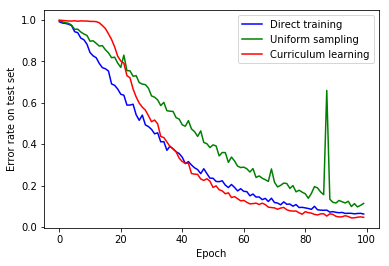

In [8]:
import matplotlib.pyplot as plt
plt.plot(error_list_direct[:100],'b')
plt.xlabel('Epoch')
plt.ylabel('Error rate on test set')
plt.plot(error_list_uniform_sampling[:100],'g')
plt.plot(error_list_curriculum[:100],'r')
plt.legend(['Direct training','Uniform sampling','Curriculum learning'])
plt.show()